In [1]:

import gempy as gp
import gempy_viewer as gpv
import pickle
import vtk
import rasterio
import pyevtk
from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from scipy.interpolate import LinearNDInterpolator
from SimPEG import maps
from SimPEG.potential_fields import gravity
from SimPEG import discretize


from gempy.core.data import GeoModel
from gempy.core.data import Grid
from gempy.core.data.grid_modules import RegularGrid


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, time
import pyvista as pv
from gempy_engine.core.data.stack_relation_type import StackRelationType


np.random.seed(55500)

Setting Backend To: AvailableBackends.numpy


In [2]:
nx, ny, nz = 50,50,50  # match the later reshaping/processing
geo_model: gp.data.GeoModel = gp.create_geomodel(
    project_name='Model1',
    extent=[4729200, 4742900,
            2047800, 2060550,
            -3500, 5500],  # x, y, z
    resolution=[nx, ny, nz],
    refinement=4,  # we will use octrees
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations=os.path.join(os.getcwd(), "Orientations.csv"),
        path_to_surface_points=os.path.join(os.getcwd(), "Points.csv"),
    )
)


In [3]:
gp.map_stack_to_surfaces(
    gempy_model=geo_model,
    mapping_object=  # TODO: This mapping I do not like it too much. We should be able to do it passing the data objects directly
    {
        "Strat_Series1": ('R1_1'),     
        "Strat_Series2": ('C2'),
        "Strat_Series3": ('C1'),
        "Strat_Series4": ('C4b'),
        "Strat_Series5": ('R2'),
        "Strat_Series6": ('R1'),
        "Strat_Series7": ('R2_1'),
        "Strat_Series8": ('C4'),
    }
)
geo_model.structural_frame  # Display the resulting structural frame


StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Strat_Series1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=R1_1,
	color=#ff3f20,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series2,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=C2,
	color=#9f0052,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series3,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=C1,
	color=#015482,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series4,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=C4b,
	color=#728f02,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series5,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=R2,
	color=#5DA629,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series6,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=R1,
	color=#443988,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series7,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=R2_1,
	color=#b271d0,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series8,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=C4,
	color=#ffbe00,
	is_active=True
)
]
)
],
	fault_relations=
[[False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False]],

c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\gempy_viewer\API\_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


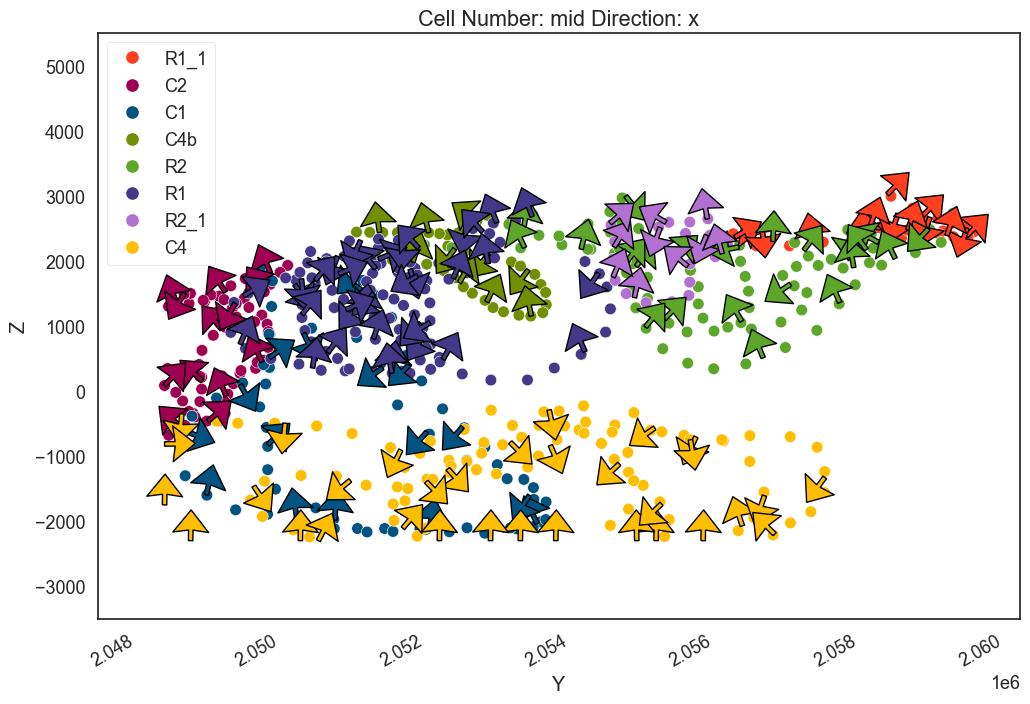

In [4]:
plot = gpv.plot_2d(geo_model, show_lith=False, show_boundaries=False, direction='x')

In [5]:
geotiff_path = os.path.join("dem.tif")

In [6]:
with rasterio.open(geotiff_path) as src:
        band = src.read(1)
        transform = src.transform


        rows, cols = np.meshgrid(
            np.arange(band.shape[0]), np.arange(band.shape[1]), indexing='ij'
        )


        xs, ys = rasterio.transform.xy(transform, rows, cols)
        xs = np.array(xs)
        ys = np.array(ys)


        xs = xs.reshape(-1,1)
        ys = ys.reshape(-1,1)
        zs = band.reshape(-1,1)

# Flatten the data into (N,3) shape
topography_points = np.vstack((xs.ravel(), ys.ravel(), zs.ravel())).T

In [7]:
gp.set_topography_from_arrays(grid=geo_model.grid, xyz_vertices=topography_points)

Active grids: GridTypes.NONE|TOPOGRAPHY|DENSE


In [8]:
geo_model.input_transform.apply_anisotropy(gp.data.GlobalAnisotropy.NONE)
geo_model.interpolation_options.kernel_options.range *= 2.4


gp.compute_model(
    gempy_model=geo_model,
    engine_config=gp.data.GemPyEngineConfig(
        backend=gp.data.AvailableBackends.PYTORCH
    )
)

Setting Backend To: AvailableBackends.PYTORCH
Chunking done: 19 chunks
Chunking done: 27 chunks
Chunking done: 29 chunks
Chunking done: 18 chunks
Chunking done: 42 chunks
Chunking done: 56 chunks
Chunking done: 13 chunks
Chunking done: 51 chunks
Chunking done: 7 chunks
Chunking done: 8 chunks
Chunking done: 11 chunks
Chunking done: 15 chunks
Chunking done: 14 chunks


Solutions(4 Octree Levels, 8 DualContouringMeshes)

In [9]:
gpv.plot_3d(model=geo_model,
            plotter_type='basic',
            show_surfaces=True,
            show_topography=True,
            show_data=False,
            show_lith=False,
            legend=True,
            )

c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\gempy_viewer\API\_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


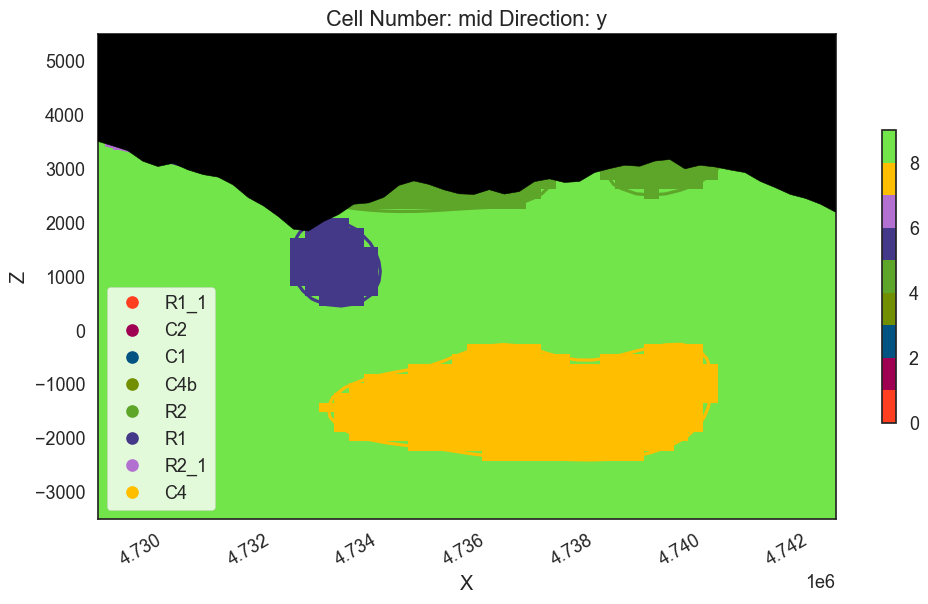

In [10]:
gpv.plot_2d(
    model=geo_model, show_topography=True, show_data=False,
)

In [12]:

vals = geo_model.grid.regular_grid.values
x_vec = np.unique(vals[:, 0])
y_vec = np.unique(vals[:, 1])
z_vec = np.unique(vals[:, 2])
reg_shape = (len(x_vec), len(y_vec), len(z_vec))


lith_reg = geo_model.solutions.raw_arrays.lith_block.reshape(50,50,50, order="F").T


topo_vals = geo_model.grid.topography.values
topo_z = topo_vals[:, 2].reshape((reg_shape[0], reg_shape[1]), order="F")


mask_air = z_vec[np.newaxis, np.newaxis, :] > topo_z[:, :, np.newaxis]
model_active = lith_reg.astype(float)
model_active[mask_air] = np.nan
model_active = model_active.T


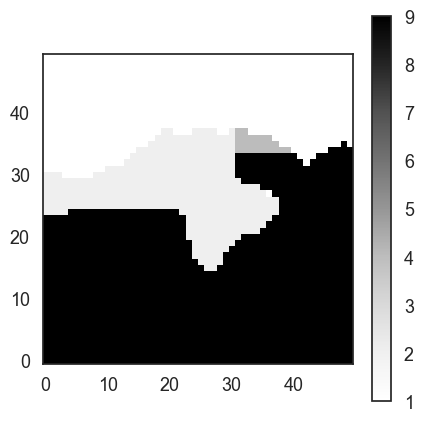

In [13]:
fig = plt.figure(figsize=(5,5))
plt.imshow(model_active[:,2,:],origin='lower')
plt.colorbar()

In [14]:
np.save('ModelB.npy', model_active)

print(f"Dimensiones del modelo 3D: {model_active.shape}")

Dimensiones del modelo 3D: (50, 50, 50)
